/home/bohdan/work/ml/programs/anaconda3/envs/bone/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  1%|          | 8/920 [00:00<00:13, 68.09it/s]

train shape: (36808, 4)


100%|██████████| 920/920 [00:15<00:00, 57.78it/s]


Few images with shape: (512, 512)


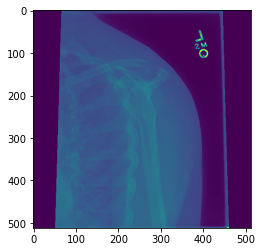

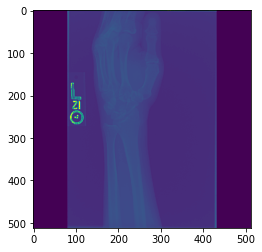

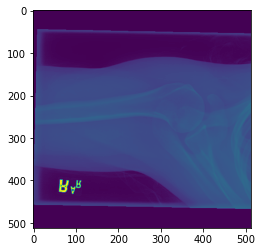

  8%|▊         | 6/79 [00:00<00:01, 57.47it/s]

Loaded 920 images and 920 labels for the current dataset
time for creating Train dataset: 0.27  mins


100%|██████████| 79/79 [00:01<00:00, 71.40it/s]


Few images with shape: (512, 512)


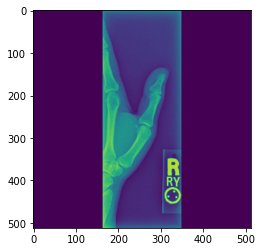

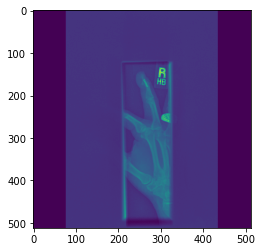

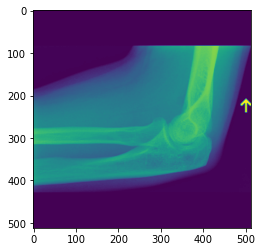

Loaded 79 images and 79 labels for the current dataset
image_plot: (512, 512, 3)


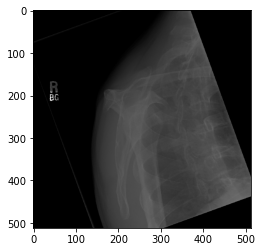

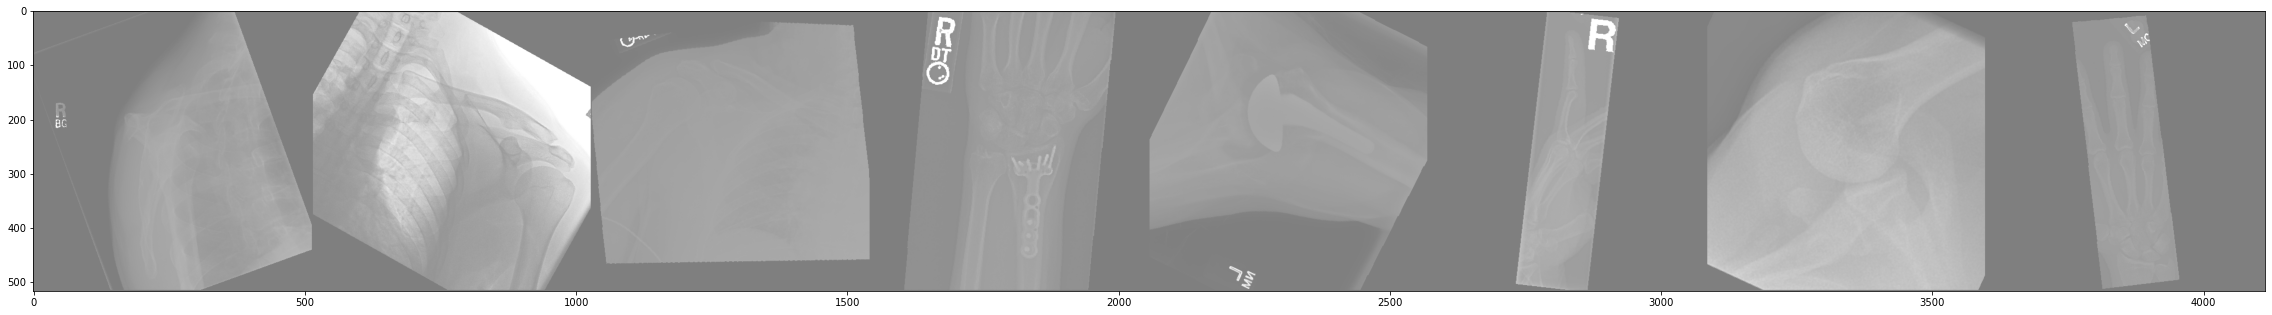

In [1]:
import time
import cv2
import argparse
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader

from torch.utils.tensorboard import SummaryWriter
from tensorboard_utils import *

from model import PretrainedDensenet
from read_data import Data
from datasets_gpu import *
from train import *
from loss import Loss
from visualize import see_samples, view_data_count
from config import INPUT_SIZE

# ------- Start tensorboard 

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/mura')


device = torch.device("cpu")

# '''
# parser = argparse.ArgumentParser(description='PyTorch Fer2013 CNN Training')
# parser.add_argument('--use_cuda', type=bool, default=False, help='device to train on')
# parser.add_argument('--samples', type=bool, default=False, help='See sample images')
# parser.add_argument('--view_data_counts', type=bool, default=False, help='Visualize data distribution')
# parser.add_argument('--num_epochs', type=int, default=5, help='Number of epochs to train on')
# parser.add_argument('--train', default=True, type=bool, help='train the model')

# opt = parser.parse_args()
class OPT:
    use_cuda=True
    samples=False
    view_data_counts=False
    num_epochs=15
    train=True
opt = OPT()


if opt.use_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        

df = Data()

train_df = df.train_df
valid_df = df.valid_df
train_labels_data = df.train_labels_data
valid_labels_data = df.valid_labels_data


if opt.samples:
    see_samples(train_df)

print("train shape:", train_df.shape)
body_type = 'WRIST'
# train_df = train_df[train_df['BodyPart']==body_type]
# valid_df = valid_df[valid_df['BodyPart']==body_type]

train_df.set_index(["FilePath", "Label"]).count(level="Label")

if opt.view_data_counts:
    view_data_count(train_df, valid_df)

if opt.train:
    # The paper uses the same standard deviation and mean as that of IMAGENET dataset
    train_transform = transforms.Compose([
#             transforms.Resize(224),
            transforms.RandomCrop(INPUT_SIZE),
            transforms.RandomHorizontalFlip(),
            transforms.RandomAffine(30, translate=None, scale=(0.95,1.3), resample=False, fillcolor=0), # 30 is rotation
            transforms.ColorJitter(brightness=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    val_transform = transforms.Compose([
            transforms.Resize(INPUT_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    time_start_dataset = time.time()
    train_dataset = MuraDataset(df=train_df,transform=train_transform)
    train_loader = DataLoader(dataset=train_dataset, batch_size=8, num_workers=2, shuffle=True)#, pin_memory=True)
    print("time for creating Train dataset:", round((time.time()-time_start_dataset)/60, 2), ' mins')
    val_dataset = MuraDataset(df=valid_df, transform=val_transform)
    val_loader = DataLoader(dataset=val_dataset, batch_size=8, num_workers=0, shuffle=True)#, pin_memory=True)

    plot_random_images_tensorboard(writer, train_loader)

    
    model = PretrainedDensenet()
    model.to(device)
#     model.load_state_dict(torch.load('model_pretrained_denselayer.pt'))
    model.load_state_dict(torch.load('models/model_360_epoch-2_kappa-0.653.pt'))
#     model.to(device)
    
    # add dropout(0.5) before last sigmoid
    
    # unfreeze whole network
    for param in model.parameters():
        param.requires_grad = True

    criterion = Loss(train_df, valid_df, device)
#     criterion = nn.BCELoss()

    # The network was trained end-to-end using Adam with default parameters β1 = 0.9 and β2 = 0.999 
    optimizer = optim.Adam(model.parameters(), betas=(0.9,0.999), lr=1e-4)

#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, mode='min', patience=10, verbose=True)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

    model_ft = train(criterion=criterion,
                     optimizer=optimizer, 
                     model=model, 
                     n_epochs=opt.num_epochs, 
                     device=device, 
                     train_loader=train_loader, 
                     val_loader=val_loader, 
                     writer=writer,
                     scheduler = scheduler)
    

##### 